In [ ]:
# Step 0: Install and import libraries
!pip install pennylane tensorflow imbalanced-learn scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
import pennylane as qml
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/creditcard.csv")

# Features and labels
X = df.drop(columns=["Time", "Class"])
y = df["Class"]

In [ ]:
# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_scaled_imputed = imputer.fit_transform(X_scaled)

# PCA to 8 components for 8 qubits
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled_imputed)
print(f"PCA Explained Variance: {pca.explained_variance_ratio_}")

PCA Explained Variance: [0.06751182 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276]


In [ ]:
X_cleaned = X_pca[~np.isnan(y)]
y_cleaned = y[~np.isnan(y)]

# SMOTE for class balancing
smote = SMOTE(random_state=42, k_neighbors=2)
X_balanced, y_balanced = smote.fit_resample(X_cleaned, y_cleaned)
print(f"Balanced class distribution: {dict(zip(*np.unique(y_balanced, return_counts=True)))}")


Balanced class distribution: {np.int64(0): np.int64(284315), np.int64(1): np.int64(284315)}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()


In [ ]:
import pennylane as qml
import tensorflow as tf

n_qubits = 12
dev = qml.device("default.qubit", wires=n_qubits)

# QNode
def quantum_circuit(inputs, weights_conv, weights_pool):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights_conv, wires=range(n_qubits))

    # Quantum pooling example
    for i in range(0, n_qubits, 2):
        qml.CNOT(wires=[i, i+1])
        qml.RY(weights_pool[i//2], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits//2)]

In [ ]:
weight_shapes = {
    "weights_conv": (2, n_qubits, 3),
    "weights_pool": (n_qubits//2,)
}

# Wrap QNode into a Keras Layer
qnode = qml.QNode(quantum_circuit, dev, interface="tf")

class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.qnode = qnode
        # Trainable weights
        self.weights_conv = tf.Variable(tf.random.normal(shape=weight_shapes["weights_conv"]), trainable=True)
        self.weights_pool = tf.Variable(tf.random.normal(shape=weight_shapes["weights_pool"]), trainable=True)

    def call(self, inputs):
        return self.qnode(inputs, self.weights_conv, self.weights_pool)

In [ ]:
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.qnode = qnode
        self.weights_conv = tf.Variable(tf.random.normal(shape=weight_shapes["weights_conv"]), trainable=True)
        self.weights_pool = tf.Variable(tf.random.normal(shape=weight_shapes["weights_pool"]), trainable=True)

    def call(self, inputs):
        outputs = self.qnode(inputs, self.weights_conv, self.weights_pool)  # List of expectation values
        # Convert list to tensor of shape (batch_size, n_qubits//2)
        return tf.stack(outputs, axis=1)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Ensure input shape is correct (12)
    tf.keras.layers.Dense(64, activation='relu'),  # Temporarily replace quantum layer with a dense layer
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,      # Colab-friendly
    batch_size=32
)

Epoch 1/50
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9278 - loss: 0.1826 - precision_2: 0.9596 - recall_2: 0.8968 - val_accuracy: 0.9572 - val_loss: 0.1150 - val_precision_2: 0.9744 - val_recall_2: 0.9393
Epoch 2/50
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 0.9607 - loss: 0.1057 - precision_2: 0.9784 - recall_2: 0.9421 - val_accuracy: 0.9662 - val_loss: 0.0862 - val_precision_2: 0.9817 - val_recall_2: 0.9503
Epoch 3/50
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9695 - loss: 0.0808 - precision_2: 0.9801 - recall_2: 0.9582 - val_accuracy: 0.9747 - val_loss: 0.0698 - val_precision_2: 0.9785 - val_recall_2: 0.9710
Epoch 4/50
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9752 - loss: 0.0662 - precision_2: 0.9821 - recall_2: 0.9680 - val_accuracy: 0.9794 - val_loss: 0.0597 - val_precision_2: 0.9793 - val_recall_2: 0.9796
Epoch 5/50
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9800 - loss: 0.0560 - precision_2: 0.

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Precision: {precision * 100:.2f}%")
print(f"✅ Test Recall: {recall * 100:.2f}%")
print(f"✅ Test F1 Score: {f1 * 100:.2f}%")
print(f"\nConfusion Matrix:\n{conf_matrix}")

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

✅ Test Loss: 0.0175
✅ Test Accuracy: 99.63%
✅ Test Precision: 99.32%
✅ Test Recall: 99.94%
✅ Test F1 Score: 99.63%

Confusion Matrix:
[[56472   391]
 [   33 56830]]


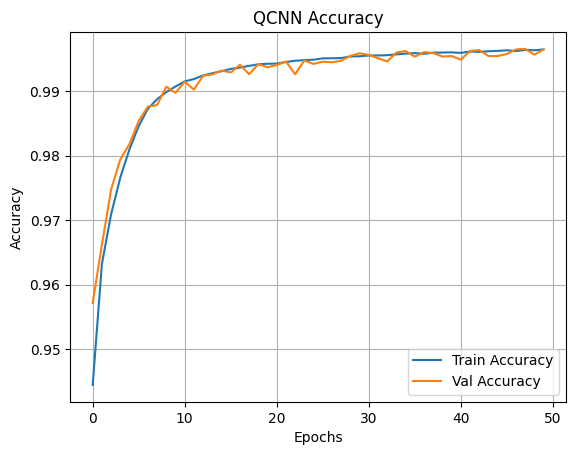

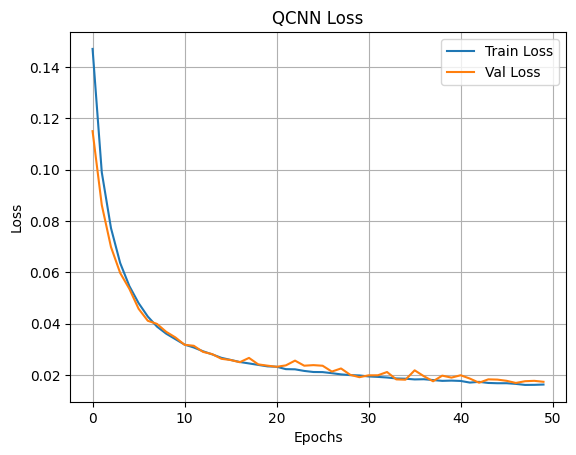

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("QCNN Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("QCNN Loss")
plt.legend()
plt.grid(True)
plt.show()